## 22520464 - 22521515
### BTT7


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [74]:
# 1 + 2. Doc file CSV va xu ly cot 'Date'
data = pd.read_csv("BT7.future-gc00-daily-prices.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(inplace=True)

In [75]:
# 3. Lam sach cot 'Close'
data['Close'] = data['Close'].replace({',': ''}, regex=True).astype(float)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(subset=['Close'], inplace=True)

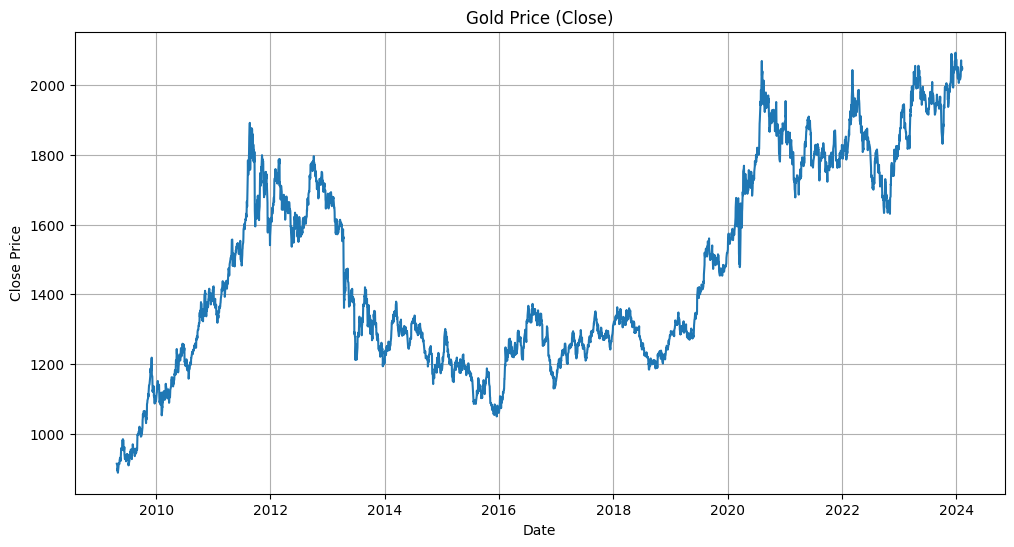

In [76]:
# 4. Ve bieu do gia Close theo thoi gian
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title("Gold Price (Close)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid()
plt.show()

In [77]:
# 5. Kiem tra tinh dung voi ADF
result_adf = adfuller(data['Close'])
print("ADF Statistic (Goc):", result_adf[0])
print("p-value (Goc):", result_adf[1])

ADF Statistic (Goc): -1.4366521533746122
p-value (Goc): 0.5645840212905483


### ==> Chuỗi gốc là không dừng (Non-Stationary) vì p-value > 0.05.

In [78]:
# 5. Sai phan 1 bac neu can
if result_adf[1] > 0.05:
    data['Close_Diff'] = data['Close'].diff()
    data.dropna(inplace=True)
    result_diff = adfuller(data['Close_Diff'])
    print("ADF Statistic (Sai phan):", result_diff[0])
    print("p-value (Sai phan):", result_diff[1])

ADF Statistic (Sai phan): -19.130833249489253
p-value (Sai phan): 0.0


### ==> Chuỗi đã chênh lệch là dừng (Stationary) vì p-value < 0.05.

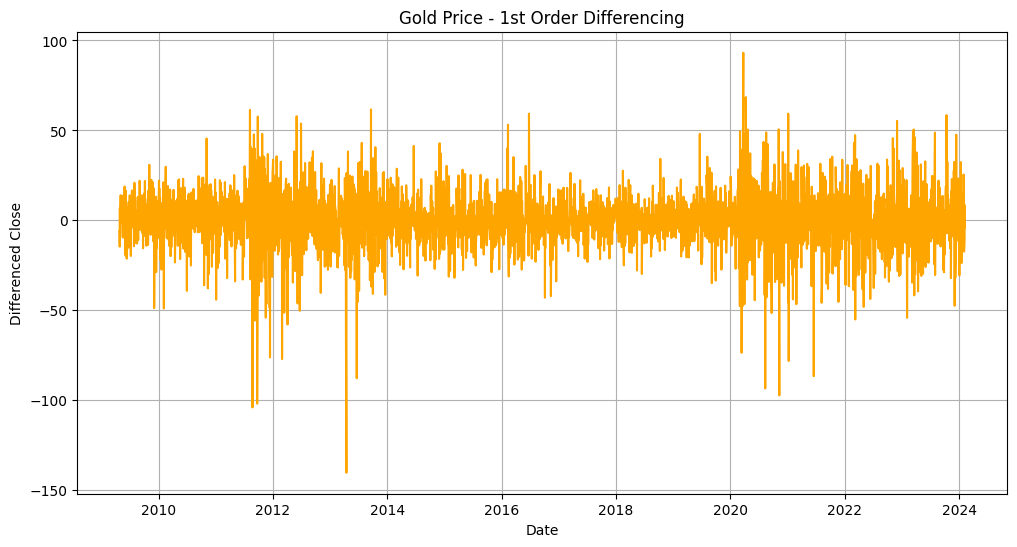

In [79]:
 # 6. Ve bieu do sai phan
plt.figure(figsize=(12,6))
plt.plot(data['Close_Diff'], color='orange')
plt.title("Gold Price - 1st Order Differencing")
plt.xlabel("Date")
plt.ylabel("Differenced Close")
plt.grid()
plt.show()

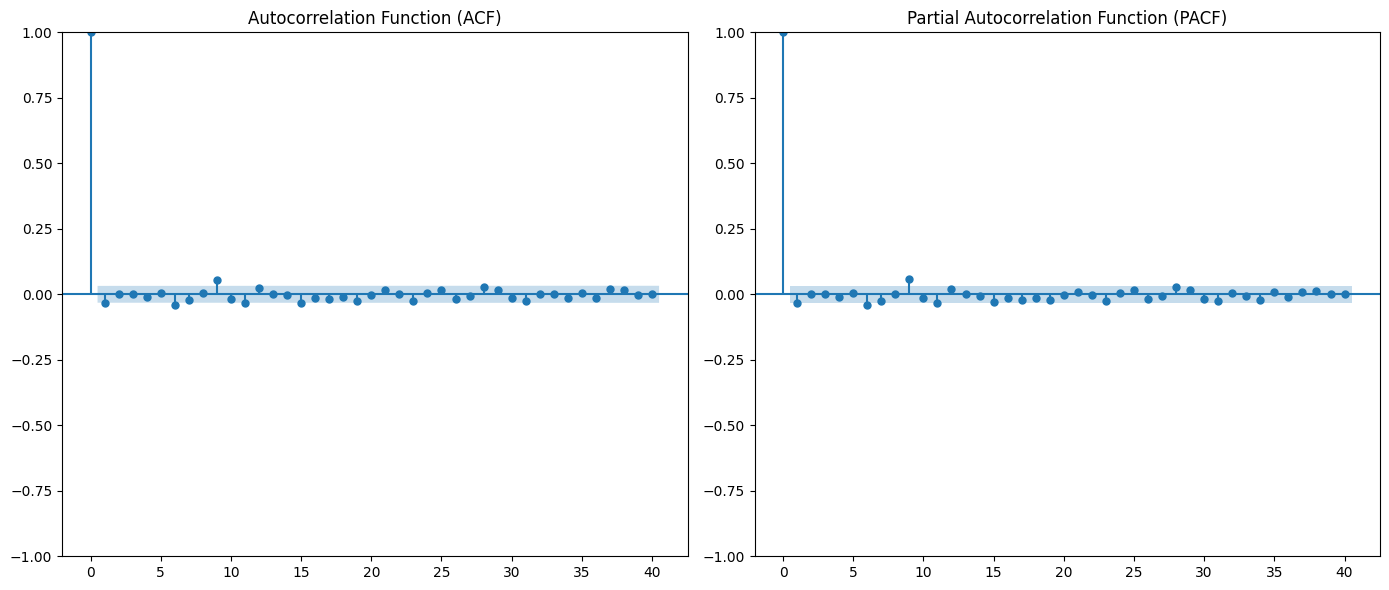

In [80]:
# 7. ACF & PACF de chon p, q
# Vẽ ACF và PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Vẽ ACF
plot_acf(data['Close_Diff'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Vẽ PACF
plot_pacf(data['Close_Diff'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


### ==> Với dữ liệu trên, chọn giá trị 1 cho cả p và q vì có một đỉnh đáng kể ở độ trễ đầu tiên cho mỗi đồ thị.

In [81]:
# 7. Chia du lieu train/test (80/20)
split_index = int(len(data) * 0.8)
train = data['Close'][:split_index]
test = data['Close'][split_index:]

# 8. Xay dung mo hinh ARIMA(1,1,1)
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2978
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12294.762
Date:                Mon, 31 Mar 2025   AIC                          24595.524
Time:                        16:25:23   BIC                          24613.520
Sample:                             0   HQIC                         24602.000
                               - 2978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4247      0.260     -1.636      0.102      -0.934       0.084
ma.L1          0.3895      0.264      1.476      0.140      -0.128       0.907
sigma2       226.3221      2.793     81.032      0.0

/home/le-minh-hoang/Coding/Study/PythonProject/PTDLKD/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/le-minh-hoang/Coding/Study/PythonProject/PTDLKD/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/le-minh-hoang/Coding/Study/PythonProject/PTDLKD/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/le-minh-hoang/Coding/Study/PythonProject/PTDLKD/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/le-minh-hoang/Coding/Study/PythonProject/PTDLKD/myenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


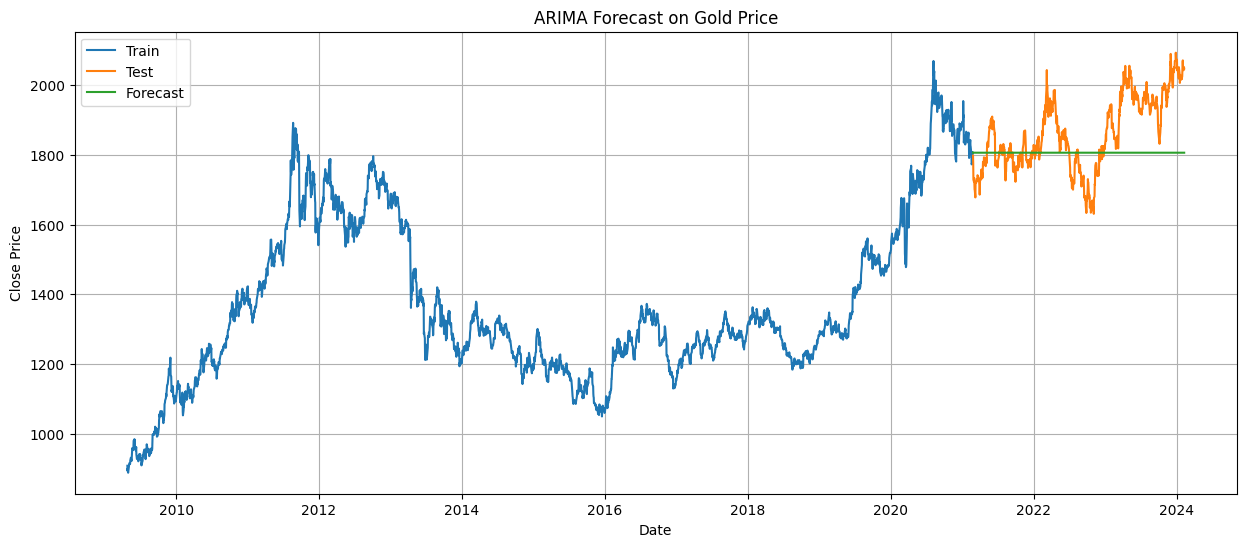

In [82]:
# 9. Du bao tren test
forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(15,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(test.index, forecast, label="Forecast")
plt.title("ARIMA Forecast on Gold Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 10. Danh gia mo hinh
rmse = sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)
print("AIC:", model_fit.aic)
print("BIC:", model_fit.bic)

RMSE: 118.53325436238086
AIC: 24595.524335765454
BIC: 24613.520349848503
